In [96]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

In [3]:
input_X = T.tensor4("X")
input_shape = [None,1,28,28]
target_y = T.vector("target Y integer",dtype='int32')

In [90]:
def fpga_sigmoid_simple(x): 
    abs_x = abs(x) 
    if (abs_x >= 5): 
        y = x/abs(x)/2+0.5
    elif (abs_x >= 2.375): 
        y = 0.03125 * x/2 + np.sign(x)*0.84375 /2+0.5
    elif (abs_x >= 1): 
        y = 0.125 * x/2 + np.sign(x)*0.625/2 +0.5 
    else: 
        y = 0.25 * x/2 + np.sign(x)*0.5/2 +0.5 
    return y

In [97]:
def fpga_sigmoid_simple(x): 
    abs_x = np.abs(x) 
    if abs_x >= 5: 
        y = 1. 
    elif abs_x >= 2.375: 
        y = 0.03125 * abs_x + 0.84375 
    elif abs_x >= 1: 
        y = 0.125 * abs_x + 0.625 
    else: 
        y = 0.25 * abs_x + 0.5 
    if (x < 0): 
        y = 1 - y 
    return y

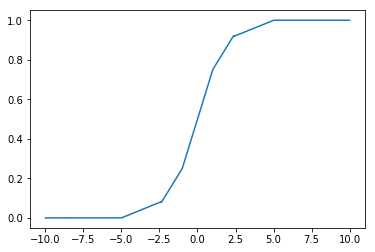

In [98]:
x = np.linspace(-10, 10, 1000)
y = [fpga_sigmoid_simple(i) for i in x]

plt.plot(x, y)

In [73]:
a = np.random.randn(400).reshape(2, 200).astype(np.float32)
r = theano.tensor.as_tensor(a)
r*6+r

Elemwise{add,no_inplace}.0

In [75]:
my_non_lin(r).eval()

array([[ 0.62050301,  0.7849952 ,  0.55991471,  0.82318747,  0.79976267,
         0.82607818,  0.79102427,  0.55443943,  0.69954336,  0.74440444,
         0.7122184 ,  0.67490965,  0.75      ,  0.54501712,  0.54326934,
         0.51057208,  0.63536471, -0.19465923,  0.53026921,  0.75      ,
         0.58525974,  0.55556136,  0.58420104,  0.51439095,  0.79194379,
         0.51192081,  0.75      ,  0.87453842,  0.55389506,  0.75      ,
         0.50769889,  0.74536186,  0.58177447,  0.85318732,  0.75      ,
         0.6777581 ,  0.50613207,  0.56243598,  0.58366561,  0.79575586,
         0.75      ,  0.61712539,  0.70800555,  0.64530569,  0.51410145,
         0.79504251,  0.65188891,  0.77178597,  0.81727171,  0.624479  ,
         0.59955382,  0.75      ,  0.78076369,  0.75284332,  0.8021791 ,
         0.61368233,  0.75968176,  0.58767462,  0.76751876,  0.66528565,
         0.51554102,  0.54246277,  0.62923914,  0.53760052,  0.77196938,
         0.55242926,  0.66360152,  0.56428289,  0.5

In [95]:
[[fpga_sigmoid_simple(i) for i in j] for j in a]

[[0.18974849954247475,
  0.10750238597393036,
  0.220042634755373,
  0.088406264781951904,
  0.10011867433786392,
  0.086960919201374054,
  0.89551212638616562,
  0.77721970528364182,
  0.84977166354656219,
  0.87220223248004913,
  0.14389079064130783,
  0.16254518181085587,
  0.93956969678401947,
  0.22749144583940506,
  0.2283653412014246,
  0.75528604537248611,
  0.81768235564231873,
  0.039667196571826935,
  0.7651346055790782,
  0.94565382599830627,
  0.79262986779212952,
  0.2222193107008934,
  0.20789947733283043,
  0.75719547038897872,
  0.89597187936306,
  0.24403958208858967,
  0.039581790566444397,
  0.93726921081542969,
  0.22305247932672501,
  0.94147801399230957,
  0.75384944956749678,
  0.12731907516717911,
  0.20911277085542679,
  0.92659364640712738,
  0.059279069304466248,
  0.1611209437251091,
  0.75306602055206895,
  0.21878202259540558,
  0.2081671804189682,
  0.89787793904542923,
  0.053553298115730286,
  0.19143728911876678,
  0.14599721878767014,
  0.82265285402

In [92]:
def my_non_lin(x):
    # x: tensor of shape (batch_size, number of features)
    abs_x = abs(x)
    fiv = abs_x // 5
    tw = abs_x // 2.375
    on = abs_x // 1
    
    y = fiv + (1-fiv)*tw*0.03125*x + (1-fiv)*tw*0.84375*np.sign(x) + (1-tw)*on*0.125*x +\
    (1-tw)*on*0.625*np.sign(x) +(1-on)*0.25*x + (1-on)*0.5*np.sign(x)
        
    return y

In [50]:
net = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X, name='input')
net = lasagne.layers.DenseLayer(net, num_units = 50, nonlinearity = my_non_lin, name='hidden')
net = lasagne.layers.DenseLayer(net, num_units = 10, nonlinearity = my_non_lin,\
                                name='output')

In [51]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net)

loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()
updates = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

UnboundLocalError: local variable 'tens' referenced before assignment

In [37]:
from random import shuffle
import math
def iterate_minibatches(X, y, batchsize):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]

In [38]:
import time
from tqdm import tqdm

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        
        
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    
    train_accuracy.append(train_acc / train_batches * 100)
    val_accuracy.append(val_acc / val_batches * 100)

  1%|          | 1/100 [00:04<06:42,  4.06s/it]

Epoch 1 of 100 took 4.053s
  training loss (in-iteration):		nan
  train accuracy:		8.99 %
  validation accuracy:		9.15 %


  2%|▏         | 2/100 [00:07<06:05,  3.73s/it]

Epoch 2 of 100 took 2.948s
  training loss (in-iteration):		nan
  train accuracy:		9.21 %
  validation accuracy:		9.90 %


  3%|▎         | 3/100 [00:09<05:33,  3.44s/it]

Epoch 3 of 100 took 2.748s
  training loss (in-iteration):		nan
  train accuracy:		9.71 %
  validation accuracy:		9.90 %


  4%|▍         | 4/100 [00:12<05:07,  3.21s/it]

Epoch 4 of 100 took 2.676s
  training loss (in-iteration):		nan
  train accuracy:		9.94 %
  validation accuracy:		9.90 %


  5%|▌         | 5/100 [00:15<04:53,  3.08s/it]

Epoch 5 of 100 took 2.792s
  training loss (in-iteration):		nan
  train accuracy:		9.94 %
  validation accuracy:		9.90 %


  6%|▌         | 6/100 [00:18<04:51,  3.10s/it]

Epoch 6 of 100 took 3.143s
  training loss (in-iteration):		nan
  train accuracy:		9.79 %
  validation accuracy:		9.90 %


  7%|▋         | 7/100 [00:24<05:58,  3.86s/it]

Epoch 7 of 100 took 5.617s
  training loss (in-iteration):		nan
  train accuracy:		9.94 %
  validation accuracy:		9.90 %


  8%|▊         | 8/100 [00:32<07:54,  5.16s/it]

Epoch 8 of 100 took 8.177s
  training loss (in-iteration):		nan
  train accuracy:		9.89 %
  validation accuracy:		9.90 %


  9%|▉         | 9/100 [00:39<08:48,  5.81s/it]

Epoch 9 of 100 took 7.300s
  training loss (in-iteration):		nan
  train accuracy:		9.73 %
  validation accuracy:		9.15 %


 10%|█         | 10/100 [00:45<08:52,  5.91s/it]

Epoch 10 of 100 took 6.150s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 11%|█         | 11/100 [00:48<07:23,  4.98s/it]

Epoch 11 of 100 took 2.808s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 12%|█▏        | 12/100 [00:51<06:23,  4.36s/it]

Epoch 12 of 100 took 2.909s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 13%|█▎        | 13/100 [00:54<05:40,  3.92s/it]

Epoch 13 of 100 took 2.878s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 14%|█▍        | 14/100 [00:57<05:08,  3.59s/it]

Epoch 14 of 100 took 2.808s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 15%|█▌        | 15/100 [01:00<04:54,  3.47s/it]

Epoch 15 of 100 took 3.193s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 16%|█▌        | 16/100 [01:03<04:38,  3.31s/it]

Epoch 16 of 100 took 2.944s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 17%|█▋        | 17/100 [01:06<04:21,  3.15s/it]

Epoch 17 of 100 took 2.784s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 18%|█▊        | 18/100 [01:09<04:35,  3.36s/it]

Epoch 18 of 100 took 3.842s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 19%|█▉        | 19/100 [01:12<04:18,  3.20s/it]

Epoch 19 of 100 took 2.807s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 20%|██        | 20/100 [01:15<04:16,  3.20s/it]

Epoch 20 of 100 took 3.210s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 21%|██        | 21/100 [01:18<04:05,  3.11s/it]

Epoch 21 of 100 took 2.896s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 22%|██▏       | 22/100 [01:21<04:02,  3.11s/it]

Epoch 22 of 100 took 3.118s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 23%|██▎       | 23/100 [01:24<03:52,  3.02s/it]

Epoch 23 of 100 took 2.793s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 24%|██▍       | 24/100 [01:27<03:40,  2.90s/it]

Epoch 24 of 100 took 2.607s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 25%|██▌       | 25/100 [01:30<03:33,  2.84s/it]

Epoch 25 of 100 took 2.711s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 26%|██▌       | 26/100 [01:32<03:25,  2.78s/it]

Epoch 26 of 100 took 2.645s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 27%|██▋       | 27/100 [01:35<03:19,  2.73s/it]

Epoch 27 of 100 took 2.600s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 28%|██▊       | 28/100 [01:37<03:12,  2.68s/it]

Epoch 28 of 100 took 2.555s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 29%|██▉       | 29/100 [01:40<03:10,  2.68s/it]

Epoch 29 of 100 took 2.699s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 30%|███       | 30/100 [01:43<03:08,  2.69s/it]

Epoch 30 of 100 took 2.715s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 31%|███       | 31/100 [01:45<03:05,  2.68s/it]

Epoch 31 of 100 took 2.650s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 32%|███▏      | 32/100 [01:48<03:04,  2.72s/it]

Epoch 32 of 100 took 2.793s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 33%|███▎      | 33/100 [01:51<02:59,  2.68s/it]

Epoch 33 of 100 took 2.587s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 34%|███▍      | 34/100 [01:53<02:54,  2.64s/it]

Epoch 34 of 100 took 2.560s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 35%|███▌      | 35/100 [01:56<02:51,  2.64s/it]

Epoch 35 of 100 took 2.621s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 36%|███▌      | 36/100 [01:59<02:58,  2.79s/it]

Epoch 36 of 100 took 3.132s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 37%|███▋      | 37/100 [02:02<03:02,  2.89s/it]

Epoch 37 of 100 took 3.141s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


 38%|███▊      | 38/100 [02:05<02:55,  2.84s/it]

Epoch 38 of 100 took 2.697s
  training loss (in-iteration):		nan
  train accuracy:		9.01 %
  validation accuracy:		9.15 %


KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 99 уровня")
else:
    print ("Нужно больше магии!")